<a href="https://colab.research.google.com/github/KingT5M/NARENDRA-SINGLE-FAULT/blob/main/NARENDRA_SINGLE_FAULT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import packages
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt 
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import randint, uniform 
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, Callback
from kerastuner import HyperModel, Hyperband

C:\Users\T5M\AppData\Local\Temp\ipykernel_6420\1781709612.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


In [2]:
# Data is stored in CSV files
healthy_data_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_002-rpm-healthy.csv'
gain_fault_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_004-gain-2.csv'
offset_fault_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_007-offset-1000.csv'
stuck_fault_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_008-stuck.csv'
noise_fault_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_009-noise.csv'
drift_fault_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_010-drift.csv'
hard_over_fault_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_010-hard-over.csv'
delay_fault_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_012-delay-2.0.csv'
spike_fault_path = r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_012-spike.csv'

# Make sure time column has 3 decimal places and all data is upto a uniform time stamp
def process_file(file_path):
    # Read CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Round off values in the first column to 3 decimal places
    df['time'] = df['time'].round(3)

    # Find the index where the 'time' column is greater than 300.66
    threshold_index = df[df['time'] > 300.66].index.min()

    # If the threshold is found, delete rows after it
    if not pd.isnull(threshold_index):
        df = df.loc[:threshold_index]

    # Save the modified DataFrame back to the CSV file
    df.to_csv(file_path, index=False)

# Apply the function to each file path
process_file(healthy_data_path)
process_file(gain_fault_path)
process_file(spike_fault_path)
process_file(hard_over_fault_path)
process_file(noise_fault_path)


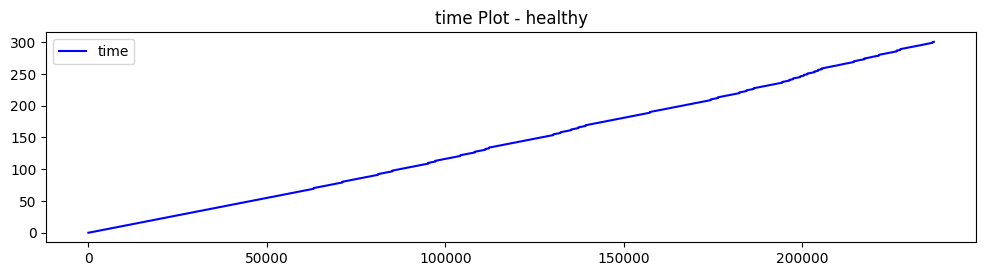

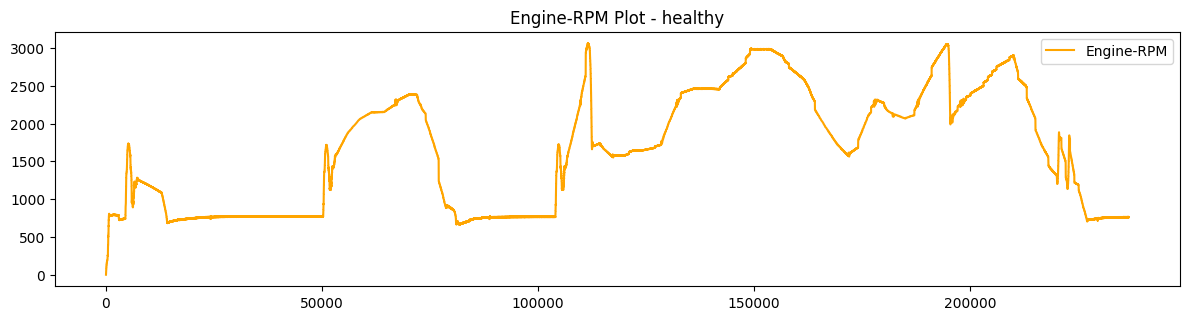

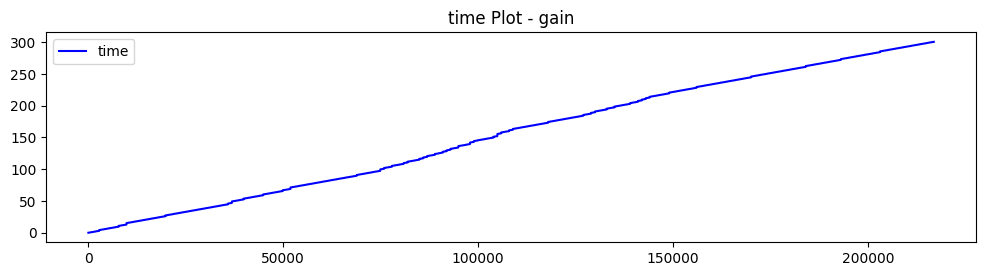

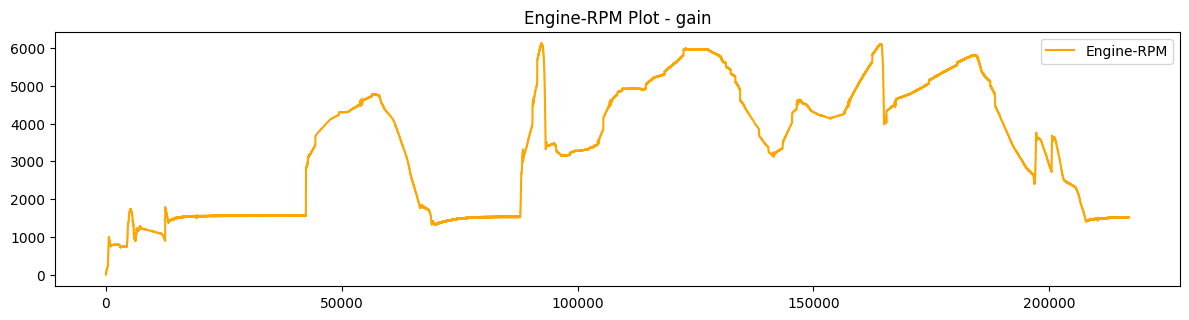

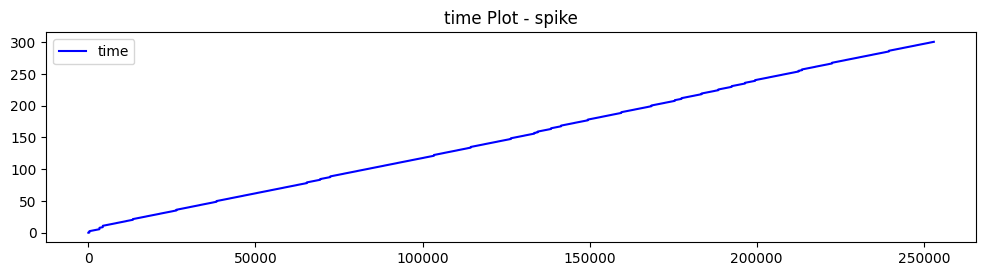

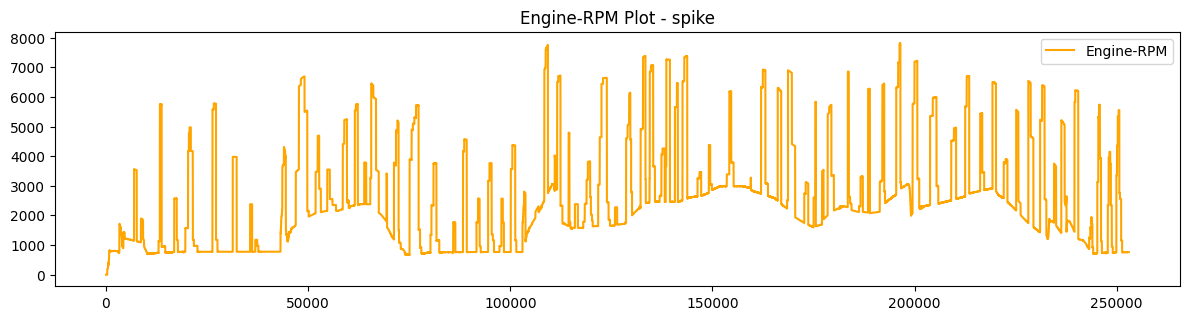

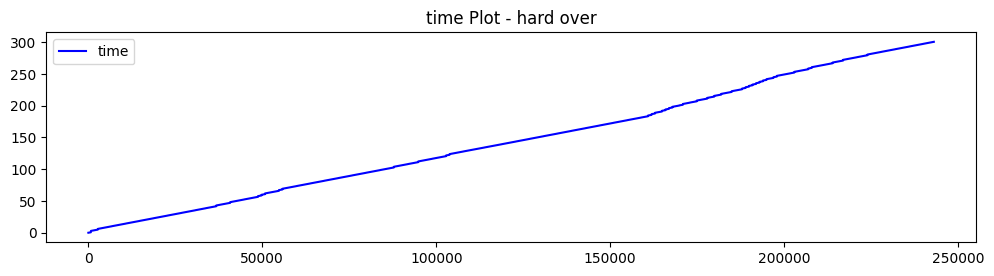

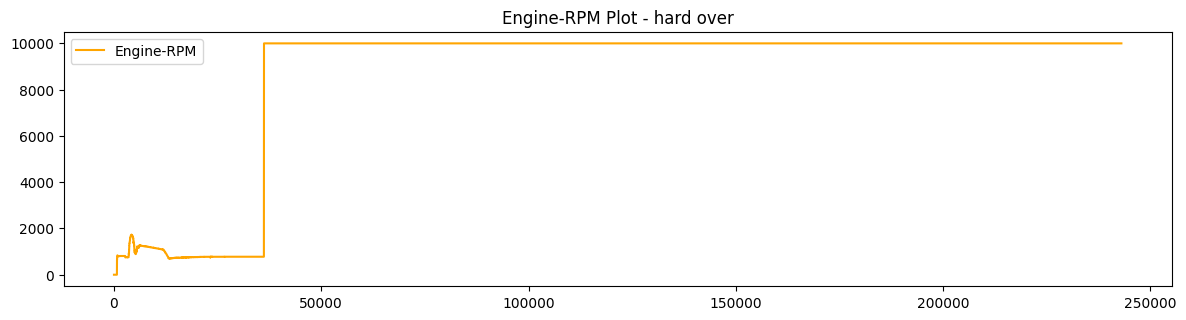

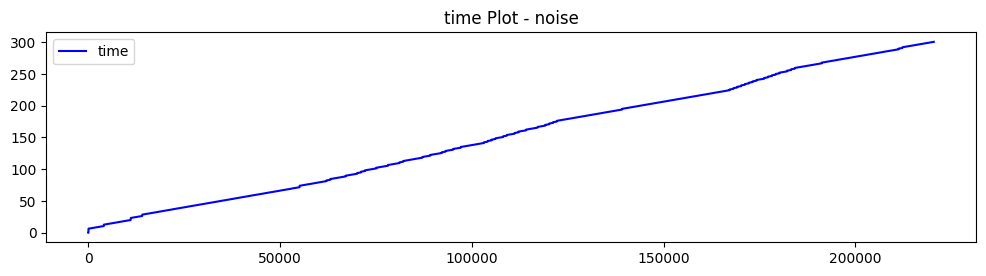

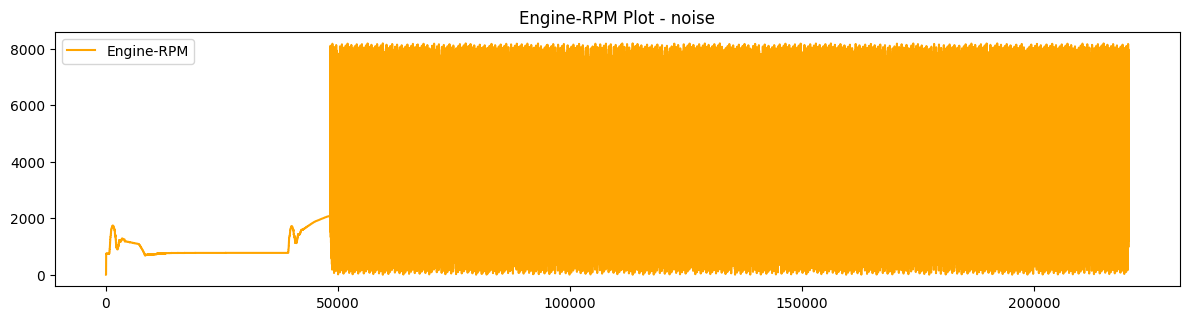

In [3]:

# Visualize data
def visualize_data(file_path, fault_type):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Plot 'Engine-RPM'
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 2)
    plt.plot(df['time'], label='time', color='blue')
    plt.title(f'time Plot - {fault_type}')
    plt.legend()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 2)
    plt.plot(df['Engine-RPM'], label='Engine-RPM', color='orange')
    plt.title(f'Engine-RPM Plot - {fault_type}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize data for each file
for file_path, fault_type in [(healthy_data_path, 'healthy'), (gain_fault_path, 'gain'),
                              (spike_fault_path, 'spike'),
                              (hard_over_fault_path, 'hard over'),
                              (noise_fault_path, 'noise')]:
    visualize_data(file_path, fault_type)

In [4]:
# File paths
file_paths = [
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_002-rpm-healthy.csv',
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_004-gain-2.csv',
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_007-offset-1000.csv',
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_008-stuck.csv',
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_009-noise.csv',
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_010-drift.csv',
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_010-hard-over.csv',
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_012-delay-2.0.csv',
    r'C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_012-spike.csv'
]

# Fault types
fault_types = [
    'healthy', 'gain', 'offset', 'stuck-at', 'noise', 'drift', 'hard-over', 'delay-time', 'spike'
]

# Iterate over each file
for file_path, fault_type in zip(file_paths, fault_types):
    # Read CSV file
    df = pd.read_csv(file_path)
    
    # Add Fault Type column and fill with respective data
    df['Fault Type'] = fault_type
    
    # Write back to CSV
    df.to_csv(file_path, index=False)

    print(f"Fault Type column added to {file_path} and filled with {fault_type} data.")


Fault Type column added to C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_002-rpm-healthy.csv and filled with healthy data.
Fault Type column added to C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_004-gain-2.csv and filled with gain data.
Fault Type column added to C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_007-offset-1000.csv and filled with offset data.
Fault Type column added to C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_008-stuck.csv and filled with stuck-at data.
Fault Type column added to C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_009-noise.csv and filled with noise data.
Fault Type column added to C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_010-drift.csv and filled with drift data.
Fault Type column added to C:\Users\T5M\Desktop\NARENDRA-SINGLE FAULT\FAULT DATASET\rec3_010-hard-over.csv and filled with hard-over data.
Fault Type column added to C:\Users\T5M\Desktop\NARENDRA-

In [5]:
# List to store DataFrames
dfs = []

# Read each CSV file and append to the list
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs, ignore_index=True)

# Display the concatenated DataFrame
print(concatenated_df)


            time  Engine-RPM Fault Type
0          0.001         0.0    healthy
1          0.002         2.0    healthy
2          0.003         2.0    healthy
3          0.004         2.0    healthy
4          0.005         2.0    healthy
...          ...         ...        ...
2284159  300.657       758.0      spike
2284160  300.658       758.0      spike
2284161  300.659       758.0      spike
2284162  300.660       758.0      spike
2284163  300.661       762.0      spike

[2284164 rows x 3 columns]


In [6]:
# Drop missing values
concatenated_df.dropna(inplace=True)

# Mix up the data by shuffling the DataFrame
concatenated_df = concatenated_df.sample(frac=1).reset_index(drop=True)

# Extract unique fault types
unique_fault_types = concatenated_df['Fault Type'].unique()

# Split the DataFrame into training, validation, and testing sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_end = int(len(concatenated_df) * train_ratio)
val_end = int(len(concatenated_df) * (train_ratio + val_ratio))

train_df = concatenated_df[:train_end]
val_df = concatenated_df[train_end:val_end]
test_df = concatenated_df[val_end:]

# Ensure all fault types are represented in each set
for fault_type in unique_fault_types:
    train_fault_type = train_df[train_df['Fault Type'] == fault_type]
    val_fault_type = val_df[val_df['Fault Type'] == fault_type]
    test_fault_type = test_df[test_df['Fault Type'] == fault_type]

    if len(train_fault_type) == 0 or len(val_fault_type) == 0 or len(test_fault_type) == 0:
        raise ValueError("Fault type '{}' not present in all datasets.".format(fault_type))

# Extract features and labels
X_train = train_df.iloc[:, :2].values  # Features
y_train = train_df.iloc[:, 2].values   # Labels

X_val = val_df.iloc[:, :2].values  # Features
y_val = val_df.iloc[:, 2].values   # Labels

X_test = test_df.iloc[:, :2].values  # Features
y_test = test_df.iloc[:, 2].values   # Labels

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Create sequences of 30
sequence_length = 30
X_train_sequences = []
y_train_sequences = []
for i in range(len(X_train_scaled) - sequence_length + 1):
    X_train_sequences.append(X_train_scaled[i:i+sequence_length])
    y_train_sequences.append(y_train_encoded[i+sequence_length-1])

X_val_sequences = []
y_val_sequences = []
for i in range(len(X_val_scaled) - sequence_length + 1):
    X_val_sequences.append(X_val_scaled[i:i+sequence_length])
    y_val_sequences.append(y_val_encoded[i+sequence_length-1])

X_test_sequences = []
y_test_sequences = []
for i in range(len(X_test_scaled) - sequence_length + 1):
    X_test_sequences.append(X_test_scaled[i:i+sequence_length])
    y_test_sequences.append(y_test_encoded[i+sequence_length-1])

# Convert sequences into arrays
X_train_array = np.array(X_train_sequences)
y_train_array = np.array(y_train_sequences)

X_val_array = np.array(X_val_sequences)
y_val_array = np.array(y_val_sequences)

X_test_array = np.array(X_test_sequences)
y_test_array = np.array(y_test_sequences)

print("Preprocessing completed successfully.")

Preprocessing completed successfully.


In [7]:
print("Shape of Training Features:", X_train_array.shape)
print("Shape of Training Labels:", y_train_array.shape)
print("Shape of Validation Features:", X_val_array.shape)
print("Shape of Validation Labels:", y_val_array.shape)
print("Shape of Testing Features:", X_test_array.shape)
print("Shape of Testing Labels:", y_test_array.shape)


Shape of Training Features: (1598885, 30, 2)
Shape of Training Labels: (1598885, 9)
Shape of Validation Features: (342596, 30, 2)
Shape of Validation Labels: (342596, 9)
Shape of Testing Features: (342596, 30, 2)
Shape of Testing Labels: (342596, 9)


In [10]:
class CustomHyperModel(HyperModel):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def build(self, hp):
        model = Sequential()

        # Hyperparameters
        cnn_layers = hp.Int('cnn_layers', min_value=0, max_value=5, default=5)
        lstm_layers = hp.Int('lstm_layers', min_value=0, max_value=5, default=4)
        dense_layers = hp.Int('dense_layers', min_value=0, max_value=5, default=0)
        max_pooling = hp.Boolean('max_pooling', default=True)
        dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.0)
        batch_norm = hp.Boolean('batch_norm', default=True)
        batch_size = hp.Int('batch_size', min_value=64, max_value=150, default=64)
        learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.001, default=0.0005, sampling='log')
        epochs = hp.Int('epochs', min_value=50, max_value=900, default=850)

        # CNN Layers
        for i in range(cnn_layers):
            model.add(Conv1D(filters=8, kernel_size=2, activation='relu', padding='same', input_shape=(30, 2)))
            if batch_norm:
                model.add(BatchNormalization())

        # Max Pooling Layer
        if max_pooling:
            model.add(MaxPooling1D(pool_size=2))

        # LSTM Layers
        for i in range(lstm_layers):
            model.add(LSTM(units=64, activation='relu', return_sequences=True))
            if batch_norm:
                model.add(BatchNormalization())

        # Flatten Layer
        model.add(Flatten())

        # Dense Layers
        for i in range(dense_layers):
            model.add(Dense(units=64, activation='relu'))
            if dropout:
                model.add(Dropout(dropout))
            if batch_norm:
                model.add(BatchNormalization())

        # Output Layer
        model.add(Dense(units=9, activation='softmax'))

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model


Reloading Tuner from hyperparameters_tuning\fault_detection\tuner0.json

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
3                 |2                 |cnn_layers
0                 |3                 |lstm_layers
0                 |1                 |dense_layers
0                 |1                 |max_pooling
2                 |0                 |dropout
2                 |0                 |batch_norm
126               |109               |batch_size
0.001             |0.001             |learning_rate
712               |411               |epochs
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
  382/49966 [..............................] - ETA: 6:23 - loss: 2.1967 - accuracy: 0.2135

: 

In [ ]:

# Define metrics callback
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_val, axis=1)

        precision = precision_score(y_true, y_pred_classes, average='weighted')
        recall = recall_score(y_true, y_pred_classes, average='weighted')
        f1 = f1_score(y_true, y_pred_classes, average='weighted')

        print(f"Validation Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

        if precision >= 0.9886 and recall >= 0.9890 and f1 >= 0.9888:
            print("Achieved desired metrics. Stopping training.")
            self.model.stop_training = True

# Define hypermodel
hypermodel = CustomHyperModel(X_train_array, y_train_array, X_val_array, y_val_array)

# Define the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperparameters_tuning',
    project_name='fault_detection'
)

# Define metrics callback
metrics_callback = MetricsCallback((X_val_array, y_val_array))

# Perform the hyperparameter search
tuner.search(
    X_train_array,
    y_train_array,
    validation_data=(X_val_array, y_val_array),
    callbacks=[metrics_callback],
    epochs=50
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found: {best_hps}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
best_model.fit(
    X_train_array,
    y_train_array,
    validation_data=(X_val_array, y_val_array),
    batch_size=best_hps.get('batch_size'),
    epochs=best_hps.get('epochs'),
    callbacks=[metrics_callback]
)

# Save the best model
best_model.save('C:/Users/T5M/Desktop/NARENDRA-SINGLE FAULT/NARENDRA-SINGLE-FAULT/best_model.h5')

# Calculate metrics on the validation set
y_pred = best_model.predict(X_val_array)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true = tf.argmax(y_val_array, axis=1)

precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Sensor fault types
fault_types = ['healthy', 'gain', 'offset', 'stuck-at', 'noise', 'drift', 'hard-over', 'delay-time', 'spike']

# Plotting precision
plt.figure(figsize=(10, 5))
plt.bar(fault_types, precision)
plt.title('Precision')
plt.xlabel('Fault Types')
plt.ylabel('Precision (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plotting recall
plt.figure(figsize=(10, 5))
plt.bar(fault_types, recall)
plt.title('Recall')
plt.xlabel('Fault Types')
plt.ylabel('Recall (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plotting F1-score
plt.figure(figsize=(10, 5))
plt.bar(fault_types, f1)
plt.title('F1-score')
plt.xlabel('Fault Types')
plt.ylabel('F1-score (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
